# Training a Neural Network

Initially, right after the neural network is created, the parameters of all layers are filled with small random values. This step is called *random initialization*. At this point, the network merely implements a series of random transformations. The next step is to gradually adjust these parameters based on the available data. This process is called *training* and consists of repeating the following steps as long as necessary.

- **Data sampling**: A batch of data (inputs and targets) are randomly selected from the training set.
- **Forward pass**: The inputs are passed through the network, and the outputs are computed.
- **Loss computation**: The mismatch between the network outputs and the targets is measured.
- **Backward pass**: The gradients of the loss with respect to the network parameters are computed.
- **Parameters update**: The network parameters are updated using the computed gradients.

Eventually, the network learns to make accurate predictions on the training data by minimizing the loss function.  In this tutorial, we will explain how to implement the training process using PyTorch.

![training](pics/training.png)

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

## Preliminaries

First of all, we load the MNIST dataset with a preprocessing pipeline that converts the images into PyTorch tensors and normalizes them to have values between 0 and 1. 

In [3]:
preprocess = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_ds = MNIST('.data', train=True,  download=True, transform=preprocess)
test_ds  = MNIST('.data', train=False, download=True, transform=preprocess)

100%|██████████| 9.91M/9.91M [00:12<00:00, 805kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 185kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 696kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.40MB/s]


Then, we define a neural network that flattens the inputs and passes them through two fully-connected layers. The first layer has 512 neurons and a ReLU activation. The second layer has no activation since we will use the cross-entropy loss, which includes a softmax activation. Both the number of input in the first layer and the number of neurons in the second layer are fixed by arguments to the constructor.

In [4]:
class SimpleNet(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(input_dim, 512)
        self.linear2 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        y = self.flatten(x)
        y = self.linear1(y)
        y = F.relu(y)
        y = self.linear2(y)
        return y

## Loss function

To control the output of a neural network, we need to be able to measure how far this output is from what we expected. This is the job of the *loss function*. It takes the prediction of the network and the expected target (what you wanted the network to output), and computes a distance score, capturing how well the network has done on this specific sample. The loss function is a key component of the training process, as it guides the optimization algorithm to adjust the network's parameters in the right direction.

PyTorch provides a list of predefined [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions). Choosing the right loss function for the right problem is extremely important, as a network will take any shortcut it can to minimize the loss. Fortunately, when it comes to common problems such as classification and regression, there are simple guidelines we can follow to choose the correct loss function.
 - **Binary cross-entropy** for a two-class classification.
 - **Categorical cross-entropy** for a many-class classification problem.
 - **Mean squared error** for a regression problem.

 Handwritten digit classification is a many-class classification problem, so we will use the categorical cross-entropy loss function. This is called `nn.CrossEntropyLoss` in PyTorch.

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

 ```{note}
You don't need to include a softmax activation in the network when using `nn.CrossEntropyLoss`, as this function computes the softmax and the cross-entropy loss together. Conversely, if you are using `nn.LogSoftmax` as the output activation, then you should use `nn.NLLLoss` instead.
 ```

## Optimizer

The fundamental trick in deep learning is to adjust the parameters of a neural network using the gradient of the loss function. This is possible because the gradient is basically a vector that tells us in which direction we should move each parameter to reduce the loss. The *optimizer* is the algorithm responsible for adjusting the network's parameters based on the computed gradients. The most common optimizer is stochastic gradient descent (SGD), but there are many [different optimizers](https://pytorch.org/docs/stable/optim.html) available in PyTorch, such as ADAM and RMSProp, that work better for different kinds of models and data.

To construct an `Optimizer`, we have to give it an iterable containing the parameters to optimize. In this case, we provide it with all the network parameters, which can be iterated over using the `parameters()` method. We can also specify optimizer-specific options, such as the learning rate.

In [6]:
model = SimpleNet(28*28, 10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

```{note}
The parameters to optimize must be tensors that have their `requires_grad` attribute set to `True`. All trainable parameters in a PyTorch model have this attribute set by default.
```

## Training loop

Finally, we have all the pieces to implement the training loop. We will break it down into two functions.
    
 - `train_step()`: This function will update the network's parameters on a single batch of data. It will compute the loss, backpropagate the gradients, and perform an optimization step.

 - `trainer()`: This function will train the network for a specified number of epochs over the entire dataset. It will call `train_step()` to do the actual work for each batch of data in the training set.
 
The training loop is the most critical part of the deep learning workflow. It is where we spend most of our time experimenting with different architectures and hyperparameters. Hence, it is good practice to encapsulate the training loop in a function and move it into a separate script, so that it can be reused easily.

```{note}
The `train_step()` and `trainer()` functions are defined in the [`train.py`](../../code/train.py) script.
```

### Function `train_step()`

This function trains a Pytorch model on a single batch of data. It takes the model, a batch of inputs and targets, the loss function, the optimizer, and the device where the data should be sent. It returns the loss of the model on the given batch.

In [1]:
import sys
sys.path.append('../../code')
from display import print_code
print_code('train_step')

def train_step(model: torch.nn.Module, 
               batch: tuple[torch.Tensor, torch.Tensor],
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               device: torch.device) -> float:
    """Trains the model on a single batch of data. Returns the loss."""
    
    # Unpack the batch
    inputs, labels = batch

    # Send data to device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)

    # Compute loss
    loss = loss_fn(outputs, labels)

    # Backward pass
    loss.backward()

    # Update model
    optimizer.step()
    optimizer.zero_grad()

    return loss.item()

### Function `training()`

This function trains a Pytorch model for a specified number of epochs. It takes the model, the training data loader, the loss function, the optimizer, and the number of epochs. It returns the training history.

In [2]:
print_code('trainer')

def trainer(model: torch.nn.Module, 
            loader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            epochs: int,
            evaluator = None,
            train_step = train_step
    ) -> dict[str, list[float]]:
    """
    Trains the model on the given data for the specified number of epochs.
    """
    
    # Preserve model device
    previous_device = next(model.parameters()).device

    # Send model to available device
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
    model.to(device)
    print(f"===== Training on {device} device =====")
    
    # Initialize history
    history = defaultdict(list)

    # Training loop
    for epoch in range(epochs):

        # Set model to training mode
        model.train()

        # Initialize loss for this epoch
        cumulative_loss = 0.0

        # Initialize progress bar
        with tqdm(total=len(loader), desc=f'Epoch {epoch+1:2d}/{epochs}') as bar:
        
            # Loop over batches
            for batch in loader:

                # Perform training step
                cumulative_loss += train_step(model, batch, loss_fn, optimizer, device)

                # Update progress bar
                bar.update()
                bar.set_postfix(train_loss=cumulative_loss / bar.n)

            # Compute average loss for this epoch
            train_loss = cumulative_loss / len(loader)
        
            # Evaluate model
            if evaluator is not None:
                metrics = evaluator.evaluate(model, device)
                bar.set_postfix(train_loss=train_loss, **metrics)

        # Record history
        history['train'].append(train_loss)
        if evaluator is not None:
            for name, value in metrics.items():
                history[name].append(value)

    # Send model back to its original device
    model.to(previous_device)

    return history

### Training the model

Let's demonstrate how to use the `trainer` function. We start by importing it from the [`train.py`](../../code/train.py) file.

In [9]:
import sys
sys.path.append('../../code')  # folder with the train.py file

from train import trainer

Next, we will train the model for 10 epochs, using a batch size of 512 and a learning rate of 0.001. Note that these hyperparameters are passed directly to the data loader and the optimizer, respectively.

In [11]:
model = SimpleNet(28*28, 10)

loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = trainer(model, loader, loss_fn, optimizer, epochs=10)

Epoch 10/10: 100%|██████████| 118/118 [00:16<00:00,  7.33it/s, train_loss=0.0423]


The function `trainer()` prints the average loss computed over each epoch, which is also returned as a list in a dictionary. This information is useful to monitor the training process and ensure that the model is learning. If the loss is not decreasing, it may be a sign that the learning rate is too high, or the model architecture is not suitable for the problem. Let's plot the training loss to see how it evolves over time.

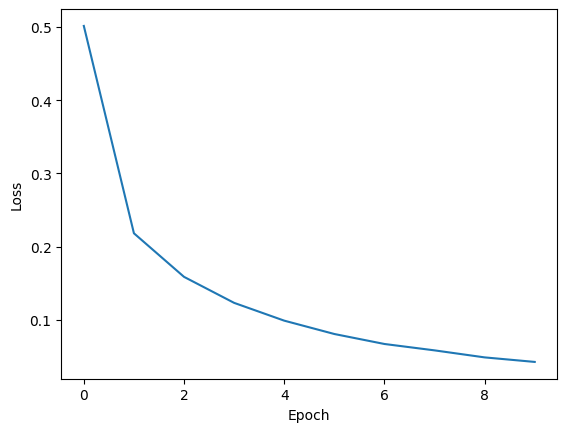

In [13]:
plt.plot(history['train'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As you can see, the training loss decreases with every epoch. That's what you would expect when training a neural network. The loss is a measure of how far the model's predictions are from the target labels. So, as the loss decreases, the model's predictions get better and better *on the training data*.

## Predictions

Now that the model is trained, we can use it to make predictions on new data. Let's select a few images from the test set and ask the model to predict the digit in each one. We will also plot the images to see what the model is working with.

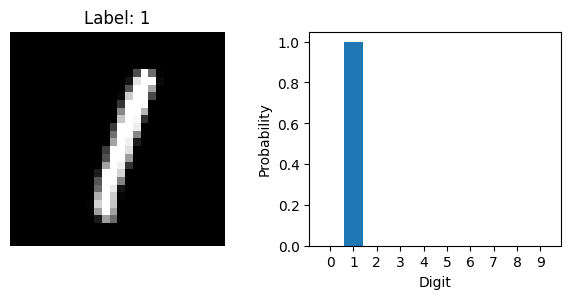

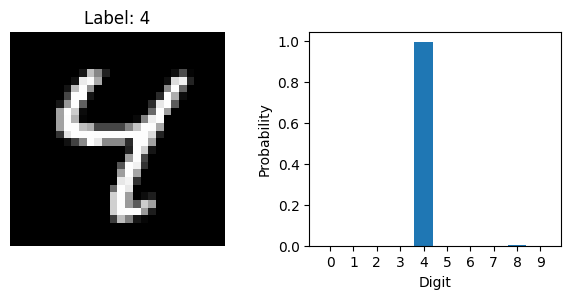

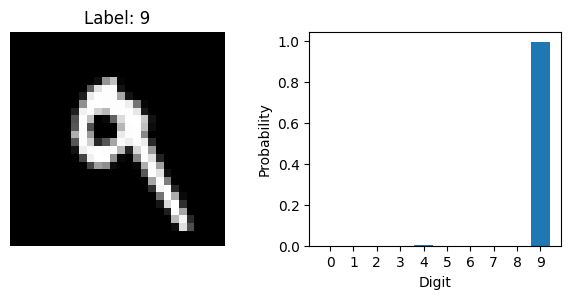

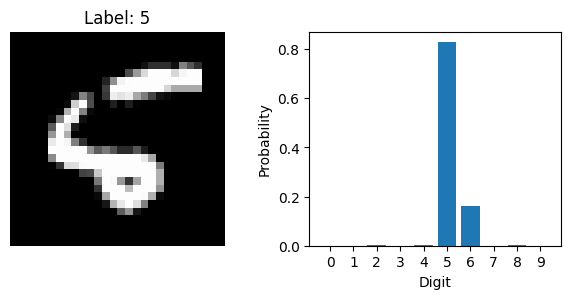

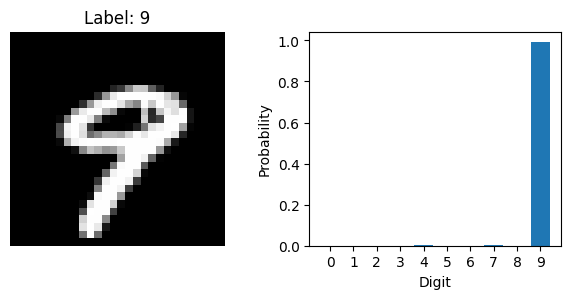

In [14]:
# Ge the device of the model
device = next(model.parameters()).device

for i in range(5, 10):

    # Get a sample
    image, label = test_ds[i]

    # Move image to device
    image = image.to(device)

    # Make prediction
    with torch.inference_mode():
        image = image.unsqueeze(0)
        scores = model(image)
        probs = F.softmax(scores, dim=1)

    # Visualize
    plt.figure(figsize=(6, 3), tight_layout=True)
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().cpu(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.bar(range(10), probs.squeeze().cpu())
    plt.xticks(range(10))
    plt.xlabel('Digit')
    plt.ylabel('Probability')
    plt.show()

## Evaluation

Now let's check how well the model performs on the test set. First, we compute the confusion matrix, which is a table that shows the number of correct and incorrect predictions for each class. It is often used to describe the performance of a multiclass classifier.

In [15]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=512)

confusion_matrix = torch.zeros(10, 10, dtype=int)

for images, labels in test_loader:
    
    with torch.inference_mode():
        images = images.to(device)
        scores = model(images)
        scores = scores.cpu()
        _, predictions = scores.max(dim=1)

    confusion_matrix.index_put_((predictions, labels), torch.tensor(1), accumulate=True)

Then, we compute the classification accuracy, which is the percentage of correctly classified images.

In [16]:
accuracy = confusion_matrix.diag().sum() / confusion_matrix.sum()

print(f'Test Accuracy: {100 * accuracy:.2f}%')

Test Accuracy: 97.73%


Let's also plot a confusion matrix to see which digits are most often confused with each other.

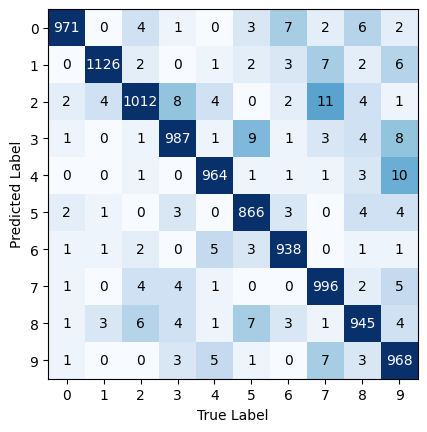

In [17]:
plt.imshow(confusion_matrix, cmap='Blues', norm=plt.Normalize(0, 20))
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.xticks(range(10))
plt.yticks(range(10))
for i in range(10):
    for j in range(10):
        plt.text(j, i, confusion_matrix[i, j].item(), ha='center', va='center', color='white' if i == j else 'black')

## Summary

In this tutorial, we learned how to train a neural network using PyTorch. Specifically, we discussed how to choose a loss function, select an optimizer, and implement the training loop. We also learned how to make predictions and evaluate the model on a test set. We hope this tutorial has given you a good understanding of the training process and how to implement it in PyTorch.
